# Document classification by inversion of distributed language representations

The skip-gram probabalistic language model is trained to, for window $b$, maximize for each word

$$
\prod_{k\neq t,~k=t-b}^{t+b} \mathrm{p}(w_k\mid w_t)
$$

This probability is calculated for all possible word pairs over a sentence (some defined short chunk of language).

In the word2vec formulation, each probability is represented as

$$
\mathrm{p}(w \mid w_I) = \prod_{j=1}^{L(w)-1} \sigma\left( \mathrm{ch}\left[\eta(w,j+1)\right] \mathbf{u}_{\eta(w,j)}^\top \mathbf{v}_{w_I} \right)
$$

where 
* $\eta(w,i)$ is the $i^{th}$ node in a binary huffman tree representation (path) for word $w$, 
* $\sigma(x) = 1/(1 + \exp[-x])$,
* and $\mathrm{ch}(\eta) \in \{-1,+1\}$ translates from left/right child to +/- one.

The binary huffman tree represents each word as a series of bits, so that the probability of word $w$ given word $w_I$ can be written as the product of probabilities that each bit is either on or off (represented above through the $\mathrm{ch}$ function).

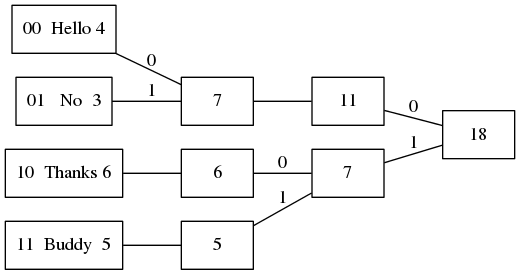

In [1]:
# An example binary huffman tree.
!dot -Tpng graphs/bht.dot -o graphs/bht.png
from IPython.display import Image
Image(filename='graphs/bht.png') 

# Note that it is a prefix tree: you know the total length after each point given bits to that point.

Given a fitted representation, we can score any new sentence (and sum across them for documents) according to the model _implied_ by the training process.  This gives a document (log) probability under that representation.  This can be calculated for language representations trained on each of the corpora associated with some class labels.  When combined with priors for each class label and inversion via Bayes rule, the document probabilities provide class probabilities.

Comparators would be any linear model regression onto phrase counts (e.g., the logistic lasso below),  the [doc2vec](http://arxiv.org/abs/1405.4053) machinery (also built into gensim), and the [Socher et al](http://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf) RNTN.  The doc2vec tool maps from documents to a vector space of fixed dimension, which can then be used as input to off-the-shelf machine learners.  The latter builds the sentiment/meaning into the model itself, and conditions upon this information during the training process.

Advantages of the inversion framework include:
* modularity: it works for any model of language that can (or its training can) be interpreted as a probabilistic model.
* transparency and replicability: a simple extension of any software for training distributed language models.
* performance (consider also 'training' the class priors, so as to correct for generative model misspecificiation).



## Example: yelp data

We'll look at some proof-of-concept on the kaggle [yelp recruiting contest data](http://www.kaggle.com/c/yelp-recruiting/data), split into star-rating files via [parseyelp.py](https://github.com/TaddyLab/deepir/blob/master/code/parseyelp.py).

In [2]:
import sys
import numpy as np
import pandas as pd
from copy import deepcopy
from gensim.models import Word2Vec
from gensim.models import Phrases

fin = open("data/yelptrain1star.txt")
firstbadreview = fin.readline()
print(firstbadreview)

 u can go there n check car out . if u wanna buy 000 there ? thats wrong move ! if u even want car service from there ? u made biggest mistake of ur life !! i had 000 time asked my girlfriend take my car there oil service guess what ? they ripped my girlfriend off by lying how bad my car now . if without fixing problem . might bring some serious accident . then she did what they said . 000 brand new tires timing belt 000 new brake pads . u know whys worst ? all of those above i had just changed 000 months before !!! what trashy dealer that ? people better off go somewhere ! 



In [3]:
## define a review generator

import re
alteos = re.compile(r'( [!\?] )')

def revsplit(l):
    l = alteos.sub(r' \1 . ', l).rstrip("( \. )*\n")
    return [s.split() for s in l.split(" . ")]

def YelpReviews( stars = [1,2,3,4,5], prefix="train" ):
    for nstar in stars:
        for line in open("data/yelp%s%dstar.txt"%(prefix,nstar)):
            yield revsplit(line)


In [4]:
## grab all sentences; good bad and ugly
allsentences = [ s for r in YelpReviews() for s in r ]
len(allsentences)

2027394

In [5]:
docgrp = {'neg': [1,2], 'pos': [5]} 
[g for g in docgrp]

['neg', 'pos']

In [6]:
reviews = { g: list(YelpReviews(docgrp[g])) for g in docgrp }
ndoc = pd.Series( {g: len(reviews[g]) for g in docgrp} , dtype="float64" )

In [7]:
reviews['neg'][0][6:10]

[['if', 'without', 'fixing', 'problem'],
 ['might', 'bring', 'some', 'serious', 'accident'],
 ['then', 'she', 'did', 'what', 'they', 'said'],
 ['000',
  'brand',
  'new',
  'tires',
  'timing',
  'belt',
  '000',
  'new',
  'brake',
  'pads']]

In [8]:
jointmodel = Word2Vec(workers=4)
np.random.shuffle(allsentences)
jointmodel.build_vocab(allsentences)  

In [9]:
model = { g: deepcopy(jointmodel) for g in docgrp }


In [10]:
def trainW2V(g, T=20):
    sent = [l for r in reviews[g] for l in r]
    model[g].min_alpha = model[g].alpha
    for epoch in range(T):
        print(epoch, end=" ")
        np.random.shuffle(sent)
        model[g].train(sent)
        model[g].alpha *= 0.9  
        model[g].min_alpha = model[g].alpha  
    print(".")


In [11]:
for g in docgrp: 
    print(g, end=": ")
    trainW2V( g )
    

neg: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 .
pos: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 .


In [12]:
def nearby(word, g):
    print(word)
    print( "%s:"%str(g), end=" ")
    for (w,v) in model[g].most_similar([word]):
        print(w, end=" ")
    print("\n")


In [13]:
for g in docgrp: nearby("food", g)
for g in docgrp: nearby("service", g)
for g in docgrp: nearby("value", g)


food
neg: pizzabytheslice meals service fazolis astoundingly absentminded cuisine slooow unmistakably meal 

food
pos: witha cuisine value bolting foood authentic breakfest grubs etcetera waite 

service
neg: sevice craftsmanship arianas !!!!!!!!!!!!!!!!! unexceptional barbarian tapinos meek recork inconsistant 

service
pos: breakfest sevice waite kendall devin serivce bolting ambience value atmoshphere 

value
neg: price quality qualtiy insider pricing craftsmanship appallingly %! prices quantity 

value
pos: price quality pricing prices rages feri overall service quantity food 



Everything to this point uses standard gensim.  For the next bit, we're using the `score` functions implemented in the [taddylab fork](https://github.com/TaddyLab/gensim).

In [14]:
testrev = { g: list(YelpReviews(docgrp[g], "test")) for g in docgrp }

In [15]:
def getprobs(rev, grp):
    sentences =  [(i,s) for i,r in enumerate(rev) for s in r]
    eta = pd.DataFrame(
            { g: model[g].score([s for i,s in sentences])  
             for g in grp } )
    probs = eta.subtract( eta.max('columns'), 'rows') 
    probs = np.exp( probs )
    probs = probs.divide(probs.sum('columns'), "rows")
    probs['cnt'] = 1
    probs = probs.groupby([i for i,s in sentences]).sum()
    probs = probs.divide(probs["cnt"], 'rows').drop("cnt", 1)
    return(probs)

In [16]:
probs = {g: getprobs(testrev[g], docgrp) for g in docgrp }

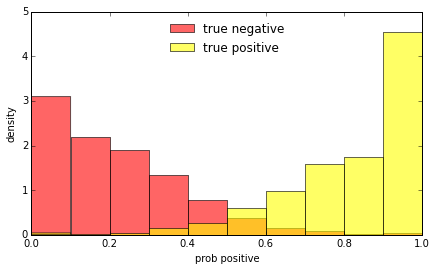

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(7,4))
plt.hist(probs['neg']['pos'],normed=1,
    color="red", alpha=.6, label="true negative", linewidth=1)
plt.hist(probs['pos']['pos'],normed=1,
    color="yellow", alpha=.6, label="true positive", linewidth=1)
plt.xlim([0,1])
plt.ylim([0,5])
plt.legend(frameon=False, loc='upper center')
plt.xlabel("prob positive")
plt.ylabel("density")
#fig.savefig("graphs/coarseprobs.pdf", format="pdf", bbox_inches="tight")


In [18]:
yhat = {g: probs[g].idxmax('columns') for g in docgrp}
mc = pd.DataFrame({
    'mcr': {g: (yhat[g] != g).mean() for g in docgrp},
    'n': {g: len(testrev[g]) for g in docgrp}
    })
print(mc)

overall = mc.product("columns").sum()/mc['n'].sum()
print("\nOverall MCR: %.3f" %overall)

          mcr     n
neg  0.064604  4427
pos  0.055019  8797

Overall MCR: 0.058


So the fit looks nice and tight. OOS we get around 6% misclassification rate on the reviews.

In [19]:
svec = np.concatenate((probs['neg']['pos'],probs['pos']['pos']), axis=0)
allrev = [[w for s in r for w in s] for r in testrev['neg']+testrev['pos']]

In [20]:
import pandas as pd
diff = pd.Series( svec )
tops = diff.order(ascending=False)[:5]
print("TOPS\n")
for i in tops.index:
    print( " ".join(allrev[i]), end="\n\n")
bots = diff.order()[:5]
print("BOTTOMS\n")
for i in bots.index:
    print( " ".join(allrev[i]), end="\n\n")


TOPS

yvonne at enlighten salon gave me my first first perm in over 000 years !! shhh dont tell because i recieved so many compliments that were follows you should quit straightening your hair it looks beautiful natural !" awesome !!!!

everything about this place top notch atmosphere service food second none will definately be coming back time time again

very yummy food friendly staff quick service good coffee ... great spot breakfast !

i went in get fitted running shoes decided check them out im soo glad i did they were helpful knowledgable i left with some great running tips shoes i chose were great price i didnt have buy into any membership best of all i love my shoes !!

000 years randy courtney valleywide properties has been serving clients find their dream home not just house that in area they take time listen your needs find area of valley that will be suited you our families lifestyle whether you looking buy sell your home let expert team at courtney valleywide take care of 

### Now, same thing but on fine scale

This copies most of the code from above and replaces it with classification amongst the 1-5 ratings.

In [21]:
docgrp_fine = {str(i) : [i] for i in range(1,6)} 
docgrp_fine

{'1': [1], '2': [2], '3': [3], '4': [4], '5': [5]}

In [22]:
for g in docgrp_fine:
    print(g, end=": ")
    reviews[g] = list(YelpReviews(docgrp_fine[g]))
    model[g] = deepcopy(jointmodel)
    trainW2V( g )


1: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 .
5: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 .
2: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 .
4: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 .
3: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 .


In [23]:
for g in docgrp_fine:
    testrev[g] =  list( YelpReviews(docgrp_fine[g], "test") )
    probs[g] = getprobs(testrev[g], docgrp_fine)
    yhat[g] = probs[g].idxmax("columns")
    

In [24]:
mc_fine = pd.DataFrame({
    'mcr': {g: (yhat[g] != g).mean() for g in docgrp_fine},
    'n': {g: len(testrev[g]) for g in docgrp_fine}
    })
print(mc_fine)

ntest = mc_fine['n'].sum()
overall_fine = mc_fine.product("columns").sum()/ntest
print("\nOverall Fine-Scale MCR: %.3f" %overall_fine)

        mcr     n
1  0.265126  2380
2  0.624328  2047
3  0.681643  2849
4  0.548017  6883
5  0.268160  8797

Overall Fine-Scale MCR: 0.435


Finally, phrases to disk for linear model analysis.  We use R, because sci-kit learn doesn't seem have a fast L1 path algorithm for logistic regression.  The models are then fit via the [gamlr](https://github.com/TaddyLab/gamlr) package, with [optimal penalty size selected via corrected AICc](http://arxiv.org/abs/1308.5623),  following the code in [linmod.R](https://github.com/TaddyLab/deepir/blob/master/code/linmod.R).

In [25]:
phraser = Phrases(allsentences,threshold=5.0)

In [26]:
for w in phraser[allsentences[0]]:
        print(w, end=" ")

mostly good service all over !! i also love walk over urban outfitter !! my_favorite of them all !!! * then h_& m so on !! : 

In [27]:
i = 0
fout = open("data/yelp_phrases.txt", "w")
for samp in ["train","test"]:
    for stars in range(1,6):  
        if samp == "train":
            rev = reviews[str(stars)]
        else:
            rev = testrev[str(stars)]
  
        for r in rev:
            for s in r:
                for w in phraser[s]:
                    if "|" not in w:
                        fout.write("%d|%s|%d|%s\n" % (i,w,stars,samp))
            i += 1


#### also, output scores per rev for reference

In [28]:
Pfine = {}

for stars in range(1,6):
    print(stars)
    Pfine['train%d'%stars] = getprobs(reviews[str(stars)], docgrp_fine)
    Pfine['test%d'%stars] = getprobs(testrev[str(stars)], docgrp_fine)
    
pmatfine = pd.concat( [Pfine['train%d'%s] for s in range(1,6)] + [Pfine['test%d'%s] for s in range(1,6)] )
pmatfine.to_csv("data/yelpw2vprobs.csv",index=False)


1
2
3
4
5


In [29]:
ntrain = [len(reviews[g]) for g in docgrp_fine]
ntest = [len(testrev[g]) for g in docgrp_fine]

In [30]:
sum(ntrain)+sum(ntest)

252863

In [31]:
i

252863

#### and finally, fit a full word2vec and export average weights to R

In [32]:
fullmodel = deepcopy(jointmodel)

In [33]:
fullmodel.min_alpha = fullmodel.alpha
for epoch in range(10):
    print(epoch, end=" ")
    np.random.shuffle(allsentences)
    fullmodel.train(allsentences)
    fullmodel.alpha *= 0.9  
    fullmodel.min_alpha = fullmodel.alpha  
print(".")


0 1 2 3 4 5 6 7 8 9 .


In [34]:
def aggvec(rev):
    av = np.zeros(fullmodel.layer1_size)
    ns = 0.0
    for s in rev:
        sv = np.zeros(fullmodel.layer1_size)
        nw = 0.0
        for w in s:
            nw += 1.0
            try:
                sv += fullmodel[w]
            except KeyError:
                # print("%s is not in vocab"%w)
                pass
        if nw > 0.0:
            av += sv/nw
    if ns > 0:
        av = av/ns
    return av
            

In [35]:
i = 0
AV = np.zeros((sum(ntrain)+sum(ntest),fullmodel.layer1_size))
for samp in ["train","test"]:
    for stars in range(1,6):  
        if samp == "train":
            rev = reviews[str(stars)]
        else:
            rev = testrev[str(stars)]
  
        for r in rev:
            AV[i,:] = aggvec(r)
            i += 1
            if np.remainder(i,10000) == 0:
                print(i)


10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000


In [36]:
np.savetxt("data/yelp_vectors.txt", AV, delimiter="|", fmt='%.6f')

In [37]:
i

252863

### Alternatively, try doc2vec analysis

In [38]:
from gensim.models.doc2vec import *
def YelpLabeledSentence( stars = [1,2,3,4,5], prefix="train" ):
    for nstar in stars:
        i = 0
        for line in open("data/yelp%s%dstar.txt"%(prefix,nstar)):
            line = alteos.sub(r' \1 . ', line).rstrip("( \. )*\n")
            lab = "%s-%d-%d" % (prefix, nstar, i)
            rev = [s.split() for s in line.split(" . ")]
            i += 1
            for s in rev:
                yield LabeledSentence(s, [lab])


In [39]:
trainsent = list(YelpLabeledSentence()) 
testsent = list(YelpLabeledSentence(prefix="test"))

In [40]:
mdm0 = Doc2Vec(workers=4, size=100, window=5, dm=0)
mdm1 = Doc2Vec(workers=4, size=100, window=5, dm=1)
%time mdm0.build_vocab(trainsent+testsent)
%time mdm1.build_vocab(trainsent+testsent)

CPU times: user 23.1 s, sys: 111 ms, total: 23.2 s
Wall time: 23.2 s
CPU times: user 23.1 s, sys: 38.7 ms, total: 23.1 s
Wall time: 23.1 s


In [41]:
def trainD2V(mod, sent, T=20):
    mod.min_alpha = mod.alpha
    for epoch in range(T):
        print(epoch, end=" ")
        np.random.shuffle(sent)
        mod.train(sent)
        mod.alpha *= 0.9  
        mod.min_alpha = mod.alpha  
    print(".")


In [42]:
%time trainD2V(mdm0, trainsent)
%time trainD2V(mdm1, trainsent)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 .
CPU times: user 49min 10s, sys: 4min 30s, total: 53min 40s
Wall time: 26min 29s
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 .
CPU times: user 56min 4s, sys: 4min 4s, total: 1h 8s
Wall time: 27min 39s


In [43]:
## turn of training of word vecs, just score label vecs
mdm0.train_words=False
mdm1.train_words=False
%time trainD2V(mdm0, testsent)
%time trainD2V(mdm1, testsent)


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 .
CPU times: user 4min 2s, sys: 29.6 s, total: 4min 31s
Wall time: 2min 30s
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 .
CPU times: user 4min 6s, sys: 26.7 s, total: 4min 33s
Wall time: 2min 23s


In [44]:
def writeD2V(mod, fname, prefix):
    v = []
    y = np.empty(0)
    x = np.empty([0,mod.syn0.shape[1]])
    for stars in range(1,6):
        labs = [ w for w in mod.vocab if re.match("%s-%d-\d+"%(prefix,stars), w) ]
        v += labs
        i = [mod.vocab[w].index for w in labs] 
        y = np.append(y, np.repeat(stars,len(i)))
        x = np.vstack( (x, mod.syn0[i,:]) )
    
    veclab = ["x%d"%d for d in range(1,x.shape[1]+1)]
    df = pd.DataFrame( x, index=v, columns=veclab )
    df["stars"] = y
    df.to_csv("data/%s.csv"%fname, index_label="id")
    

In [45]:
for prefix in ["train","test"]:
    writeD2V(mdm0, "yelpD2V%s0"%prefix, prefix)
    writeD2V(mdm1, "yelpD2V%s1"%prefix, prefix)


### linear modelling in R

The rest -- forward linear and logistic modelling -- will happen in R to make sure we're comparing linear apples to linear apples.

In [50]:
!Rscript code/linmod.R

[1] 252855
Read 228235 rows and 102 (of 102) columns from 0.433 GB file in 00:00:04
Read 228235 rows and 102 (of 102) columns from 0.434 GB file in 00:00:04

**** W2V INVERSION ****
** COARSE **
mcr 0:0.247, 1:0.064, 
overall: 0.099 diff: 0.099 deviance: 0.6818865 
** NNP **
mcr (0,2]:0.154, (2,3]:0.783, (3,5]:0.093, 
overall: 0.19 diff: 0.25 deviance: 1.385381 
** FINE **
mcr 1:0.265, 2:0.624, 3:0.682, 4:0.548, 5:0.268, 
overall: 0.435 diff: 0.598 deviance: 2.912396 

*** COUNTREG ***
** COARSE **
Warning message:
In gamlr(x[-test, ], ycoarse[-test], family = "binomial", lmr = 0.001) :
  numerically perfect fit for some observations.
mcr 0:0.324, 1:0.027, 
overall: 0.084 diff: 0.084 deviance: 0.4127019 
** NNP **
mcr (0,2]:0.453, (2,3]:0.844, (3,5]:0.012, 
overall: 0.2 diff: 0.282 deviance: 1.023203 
** FINE **
mcr 1:0.479, 2:0.754, 3:0.773, 4:0.359, 5:0.233, 
overall: 0.41 diff: 0.575 deviance: 2.022462 

*** W2V and COUNTREG NNP ***
mcr (0,2]:0.31, (2,3]:0.787, (3,5]:0.035, 
overall

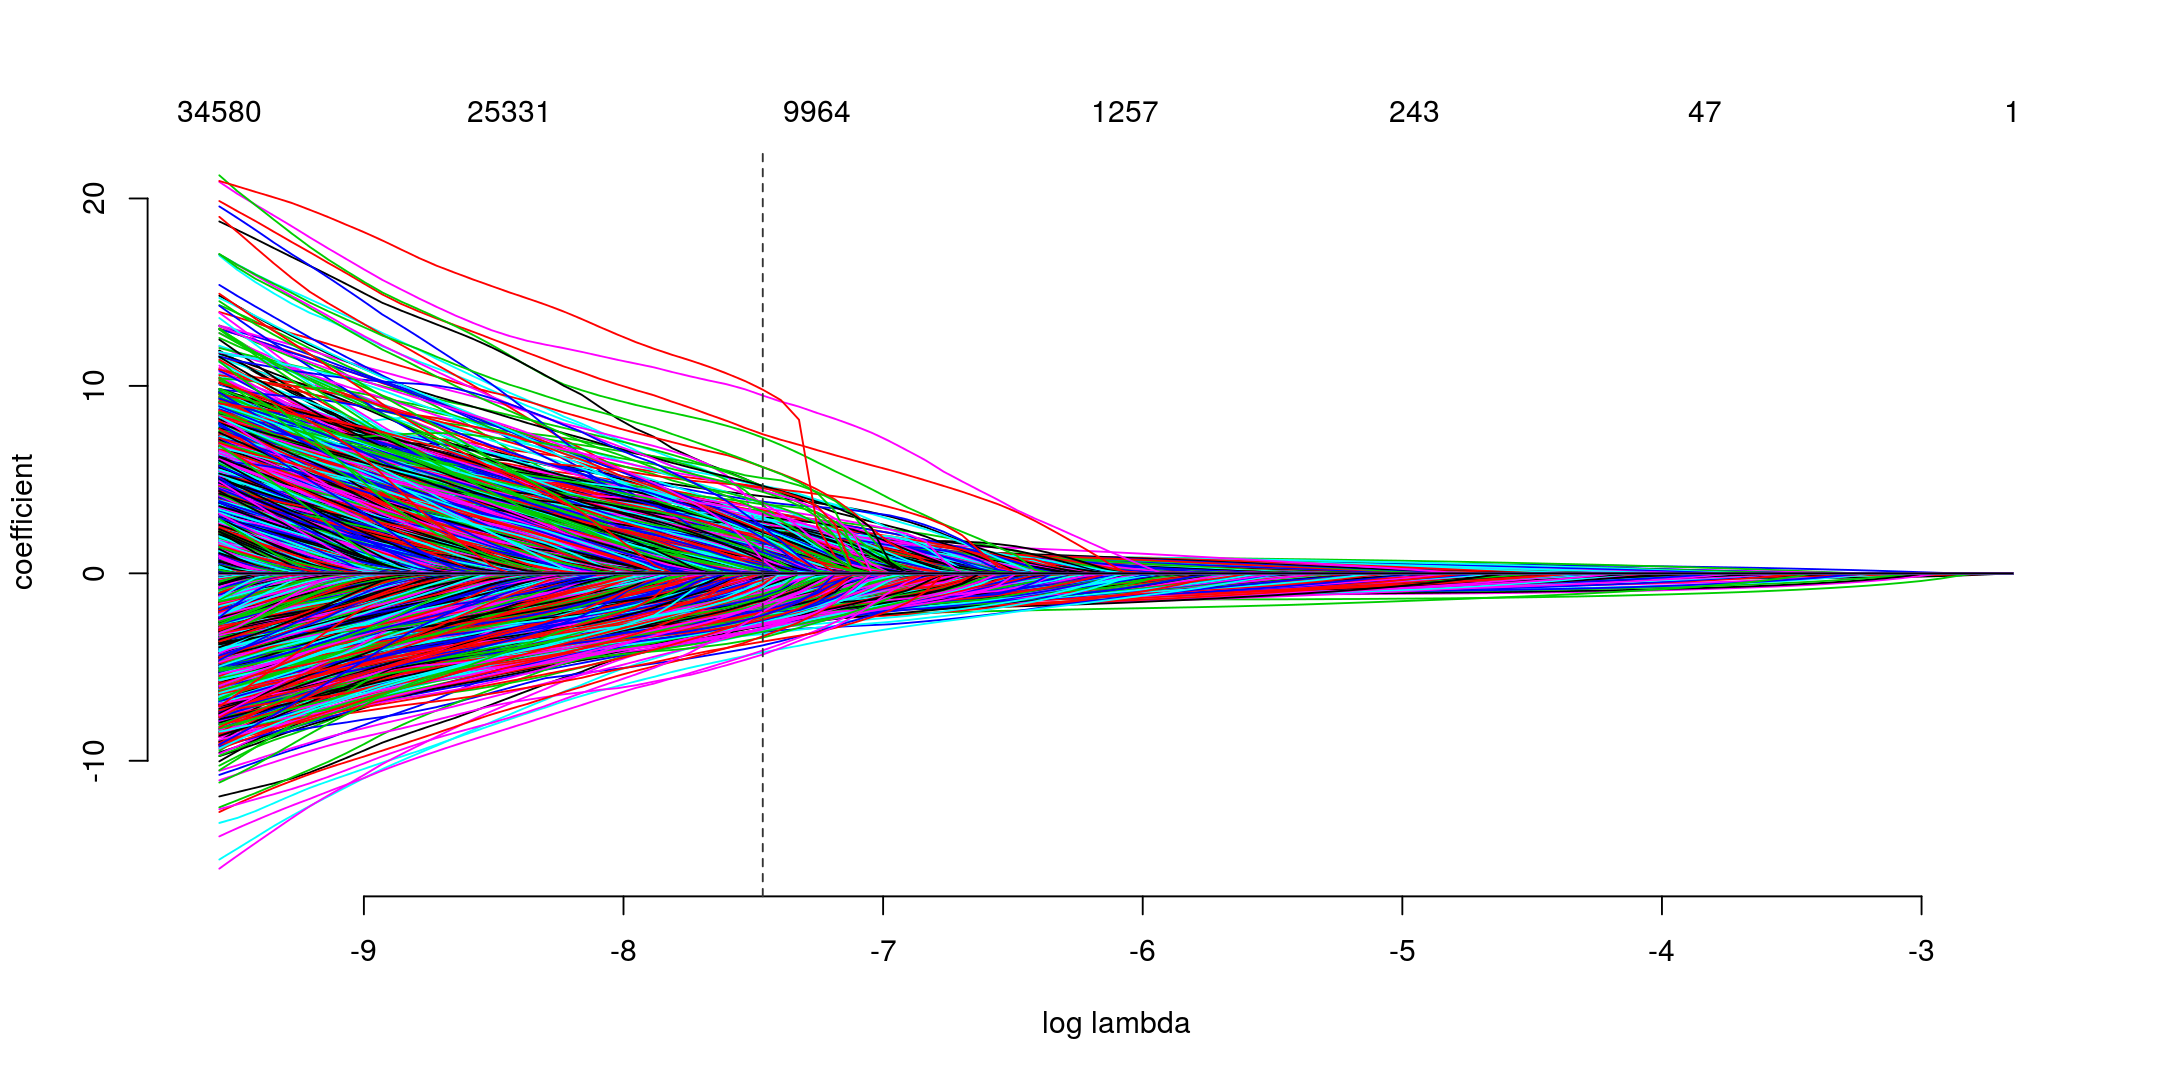

In [55]:
Image(filename='graphs/yelp_logistic.png', width=600,height=300)
